## In this notebook, we will produce a matrix containing all of the lightcurves in our sample (with some necessary modifications along the way) and we will implement K-Means clustering on the resultant matrix

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd
import os
import time
import msc_tools as mt
from sklearn import cluster
from sklearn.preprocessing import scale

In [2]:
mast_data_path = '/Users/waderoemer/Desktop/MScThesis/MAST_data/'

### Make a histogram of the _length_ of all the light curves in our sample

In [ ]:
times = [] # this will be the array of total time for each LC

for file in os.listdir(mast_data_path):
    try:
        hdu = fits.open(mast_data_path + file)
        data = hdu[1].data
        t = data['TIME'][-1] - data['TIME'][0]
        times += [t]
    except OSError: # work around the .ipynb_checkpoints and .DS_Store that come up with os.listdir()
        continue

In [ ]:
print(f'''Number of LCs in sample: {len(times)}
Longest Observation: {max(times) } days 
Shortest Observation: {min(times)} days''')

Text(0.5, 0, 'Length of LC [days]')

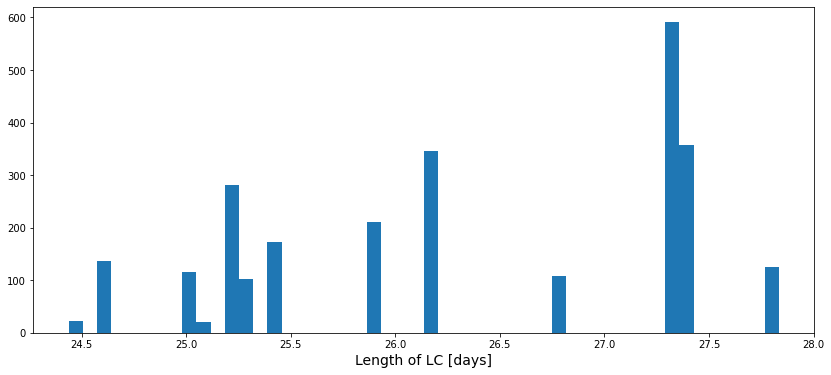

In [5]:
plt.figure(figsize = [14,6])
plt.hist(times,bins = 50)
plt.xlabel('Length of LC [days]', fontsize = 14)

### Starting in sector 27, TESS began to observe at 10min cadence instead of 30min. So, we need to rebin any lightcurves with 10min cadence as the first step to making all of the lightcurves have the same length

In [3]:
def rebin_lc(data):
    flux = []
    i = 0
    while i <= len(data['FLUX']):
        flux_i = data['FLUX'][i][2][2] + data['FLUX'][i+1][2][2] + data['FLUX'][i+2][2][2]
        flux.append(flux_i)
        i += 3
        # if len(data['FLUX']) is not of length 3n then we have to drop the last 1-2 values
        if i+3 > len(data['FLUX']):
            break
    return flux

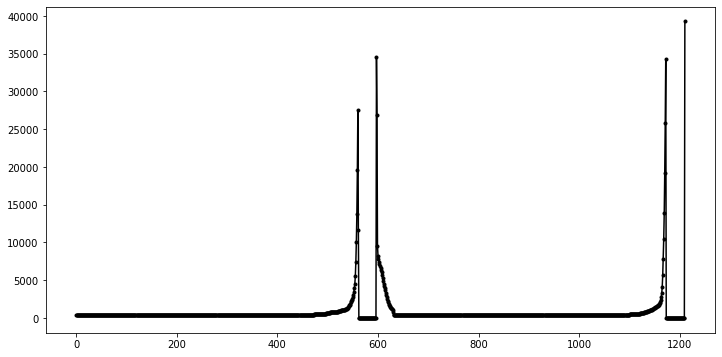

In [4]:

hdu = fits.open('MAST_data/tess-s0029-1-1_345.423250_-30.639320_5x5_astrocut.fits')
data = hdu[1].data

x = rebin_lc(data)
t = np.arange(0,len(x))
plt.figure(figsize = [12,6])
plt.plot(t,x,'k.-')

In [ ]:
## TODO: test rebinning: make a plot of the same LC before and after rebinning

### Produce a matrix of all light curves. The rebinning occurs within the function if TESS Sector is $\geq 27$. 
### Each row will correspond to the normalized light curve values, so each column will be a time bin. From the histogram produced above, we know that all of the light curves have at least 24 days of observation, so we will trim all of the light curves down to this length.

24 days of observation corresponds to :
$$
24 days \times \frac{24 hrs}{1 day} \times \frac{60 mins}{1 hr} \times \frac{1 bin}{30 mins} = 1152 bins
$$

In [41]:
## unknown issue: the min. number of bins is coming out to be 968 (~20 days)... no clue why this is happening

## will investigate further, but going to create the matrix with 968 bins for now to at least try the analysis

## --> might be an issue in the rebinning function!!
##     - try rebinning all 10min cadence LCs and then use np.min() on the length of them all

In [28]:
def produce_the_matrix(n_bins=968):
    matrix = [] # this will be the array of LCs
    
    for file in os.listdir(mast_data_path):
        try:
            hdu = fits.open(mast_data_path + file)
            data = hdu[1].data
            flux = []
            sector = hdu['PRIMARY'].header['SECTOR']
            if sector >= 27: # TESS cadence changed from 30min to 10min in Sect. 27; rebin these to 30min
                flux = rebin_lc(data)               
                for i in range(len(flux)):
                    flux_i = flux[i]
                    flux.append(flux_i)
                flux = flux / np.max(np.abs(flux)) # normalize each LC
                flux = flux[:n_bins] # trim to 24 days
                matrix += [flux]
                
            else:         
                for i in range(len(data['FLUX'])):
                    flux_i = data['FLUX'][i][2][2] # [frame][row][col]
                    flux.append(flux_i)
                flux = flux / np.max(np.abs(flux)) # normalize each LC
                flux = flux[:n_bins] # trim to 24 days
                matrix += [flux]
            
        except OSError:
            continue
    
    
    return matrix

In [29]:
matrix = produce_the_matrix()

/var/folders/6q/n5vnbbxx2fb6v2txsv4jxq0r0000gn/T/ipykernel_8663/8273409.py:16: RuntimeWarning: invalid value encountered in true_divide
  flux = flux / np.max(np.abs(flux)) # normalize each LC
/var/folders/6q/n5vnbbxx2fb6v2txsv4jxq0r0000gn/T/ipykernel_8663/8273409.py:24: RuntimeWarning: invalid value encountered in true_divide
  flux = flux / np.max(np.abs(flux)) # normalize each LC


In [30]:
## move this into the produce_the_matrix() function
# why does this even need to happen ? 
n_bins = 968
matrix_df = {}
for i in range(n_bins):
    col = []
    for j in range(len(matrix)):
        col.append(matrix[j][i])
    matrix_df.setdefault(f'bin_{i}', col)

## move this into the produce_the_matrix() function under a condition 'if save'
matrix_df = pd.DataFrame(matrix_df)
matrix_df.to_csv('TheMatrix_968_bins_renormalized.csv')

In [3]:
the_matrix = pd.read_csv('TheMatrix_968_bins_renormalized.csv').drop('Unnamed: 0', axis = 1).interpolate()
#TODO: add the interpolate() method to the function that produces the matrix
print('\n\t\t\t\t\t\t*** THE MATRIX ***\n\t\t\t\t\t\t------------------')
the_matrix


						*** THE MATRIX ***
						------------------


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_958,bin_959,bin_960,bin_961,bin_962,bin_963,bin_964,bin_965,bin_966,bin_967
0,0.499788,0.498072,0.496276,0.496971,0.495684,0.495557,0.497951,0.494430,0.497718,0.492909,...,0.489421,0.492391,0.491975,0.491216,0.491803,0.490458,0.490742,0.488062,0.492293,0.491121
1,0.267229,0.274614,0.279207,0.284201,0.289604,0.293805,0.295526,0.300194,0.305464,0.310266,...,0.280522,0.281243,0.282227,0.282588,0.283469,0.284396,0.284537,0.286393,0.286935,0.288739
2,0.005097,0.005074,0.005105,0.005075,0.005085,0.005107,0.005110,0.005105,0.005121,0.005122,...,0.005029,0.005066,0.005053,0.005102,0.005072,0.005107,0.005076,0.005089,0.005087,0.005071
3,0.179723,0.179551,0.180770,0.180518,0.180040,0.179597,0.180611,0.179646,0.179279,0.180480,...,0.260962,0.261376,0.263229,0.264432,0.266314,0.267003,0.267488,0.268112,0.268632,0.269137
4,0.695778,0.695385,0.700574,0.692955,0.700105,0.697656,0.697976,0.698035,0.695481,0.695331,...,0.703921,0.704145,0.703890,0.703777,0.704866,0.700165,0.703577,0.702235,0.700372,0.705204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,0.007617,0.007641,0.007621,0.007701,0.007669,0.007652,0.007662,0.007682,0.007663,0.007637,...,0.007687,0.007664,0.007637,0.007684,0.007650,0.007680,0.007640,0.007667,0.007664,0.007660
2585,0.009525,0.009615,0.009510,0.009539,0.009506,0.009564,0.009544,0.009519,0.009538,0.009538,...,0.009456,0.009481,0.009470,0.009557,0.009469,0.009494,0.009501,0.009458,0.009511,0.009473
2586,1.000000,0.825544,0.695653,0.604698,0.539134,0.488219,0.445844,0.409053,0.376684,0.348704,...,0.016418,0.016322,0.016391,0.016298,0.016440,0.016406,0.016431,0.016389,0.016365,0.016357
2587,0.035566,0.035652,0.035748,0.035562,0.035572,0.035714,0.035526,0.035569,0.035633,0.035552,...,0.034905,0.035116,0.035191,0.035107,0.034937,0.034980,0.035076,0.034953,0.035033,0.035236


### A quick search for pulsators with FFT and some logic:

In [6]:
# TODO: write code that generates FFT for each LC and then searches for any with peaks above 90% confidence
# Note: don't forget to establish the Nyquist frequency!

#freq = fft.fftfreq(len(lc))
#ft = fft.fft(lc)
def find_pulsator(lc):
    freq = fft.fftfreq(len(lc), d = 30)
    ft = fft.fft(lc)
    

### Run k-means clustering

In [4]:
data = np.asarray(the_matrix)
type(data)

numpy.ndarray

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25, random_state=0)
n_samples, n_features = train.shape
print('n_samples:', n_samples, 'n_features:', n_features)

n_samples: 1941 n_features: 968


In [6]:
train.shape, test.shape

((1941, 968), (648, 968))

In [7]:
n_kclusters = 6
# Create the KMeans model
clf = cluster.KMeans(init='k-means++', n_clusters=n_kclusters, random_state=42)

# Cluster the full data 
clf.fit(train)

KMeans(n_clusters=6, random_state=42)

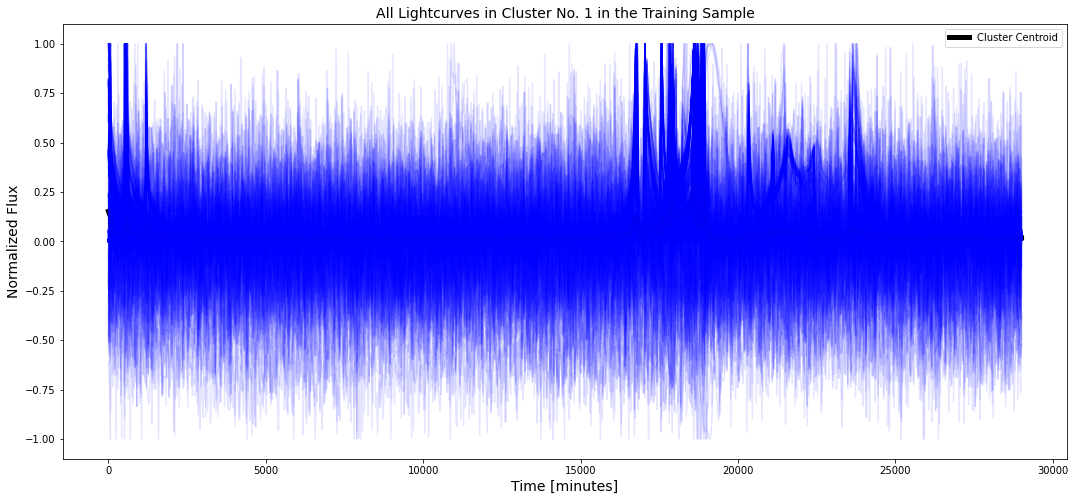

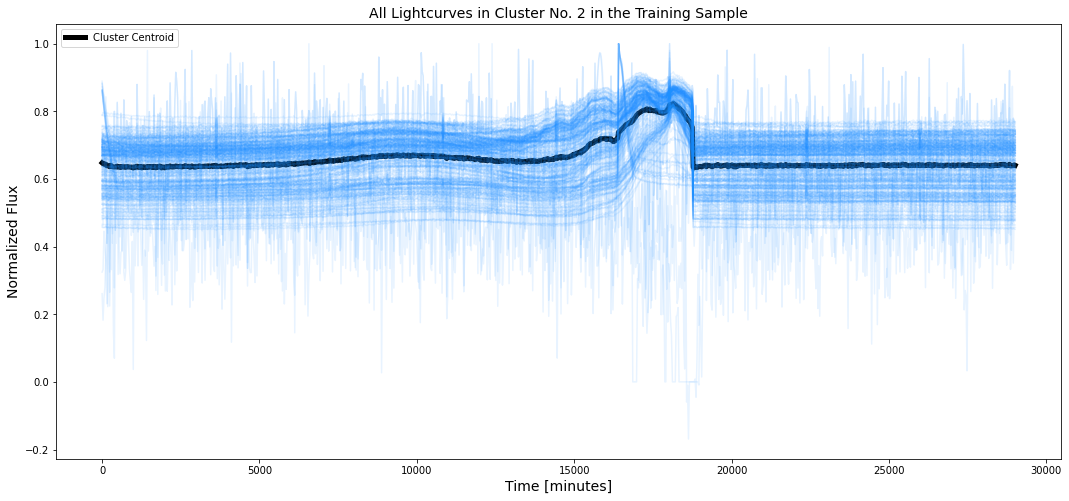

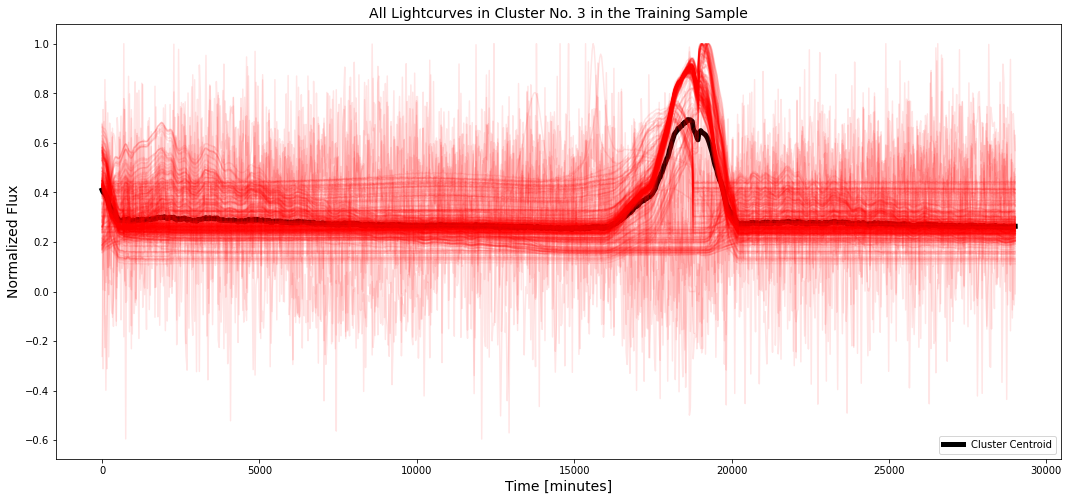

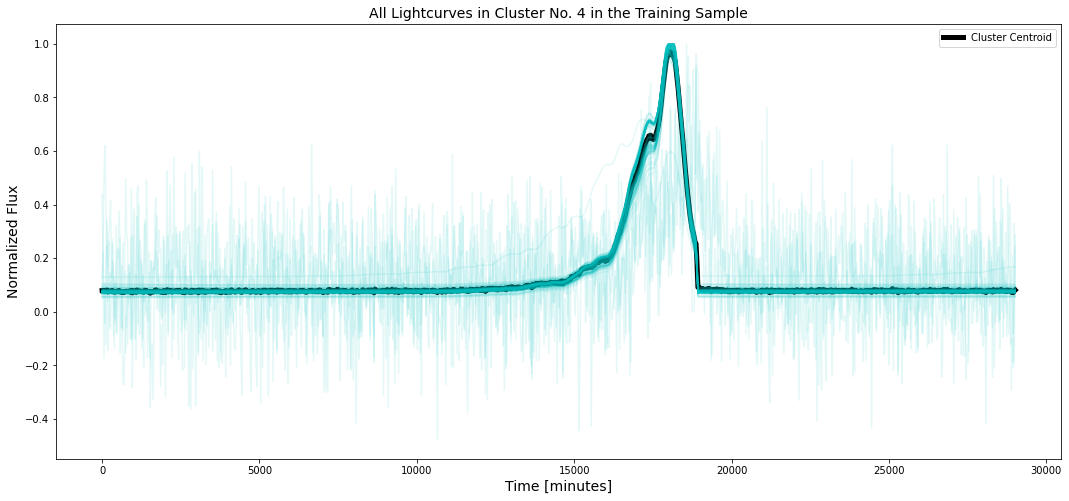

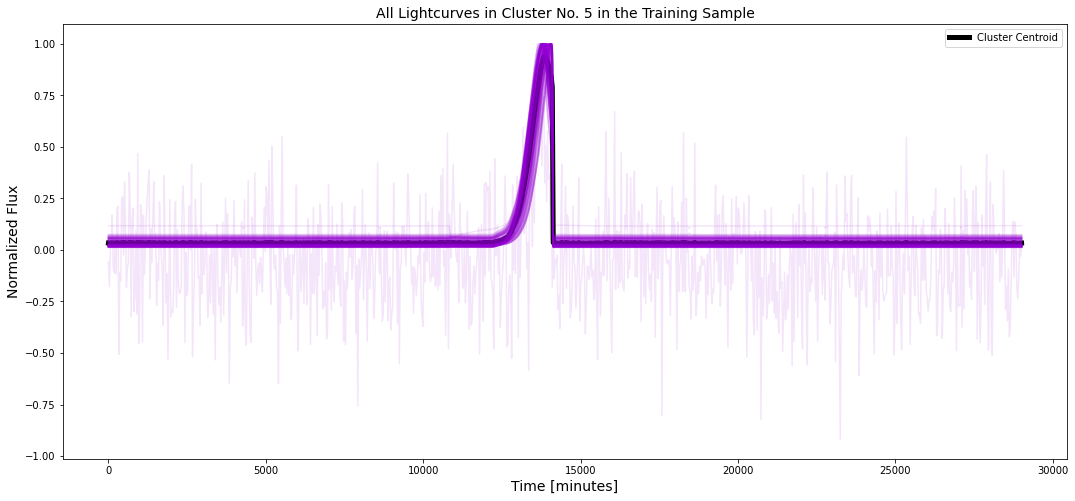

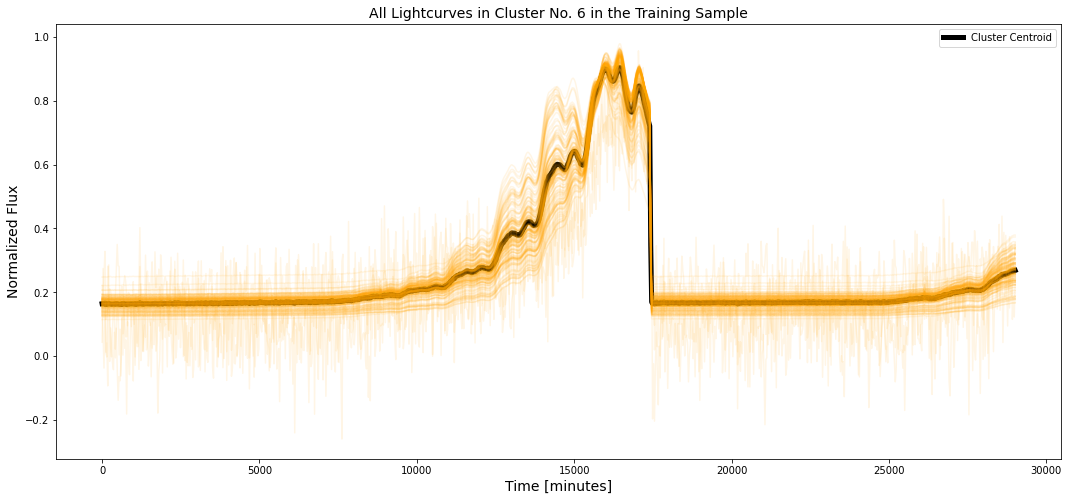

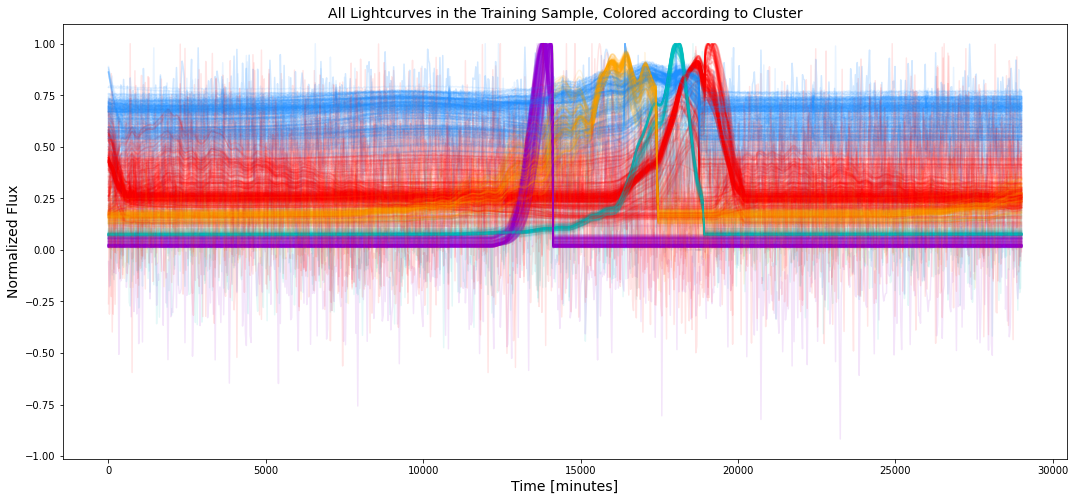

In [13]:
P = clf.predict(train)
cluster_colors = ['blue','dodgerblue', 'red', 'c', 'darkviolet', 'orange']
colors = list(map(lambda x: cluster_colors[x] % (x), P))

# make an individual plot to see how well the LCs for their respective clusters resemble each other
# (ie how well did the clustering sort them out in terms of shape?)
for m in range(n_kclusters):
    plt.figure(figsize = [18,8])
    plt.xlabel('Time [minutes]', fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.title(f'All Lightcurves in Cluster No. {m+1} in the Training Sample', fontsize = 14)
    time = np.arange(0,len(train[0,:])*30, 30)
    plt.plot(time, clf.cluster_centers_[m], 'k-', label = 'Cluster Centroid', linewidth = 3)
    plt.legend()

    for x in range(train.shape[0]):
        if P[x] == m:
            plt.plot(time, train[x,:], c = colors[x], linestyle = '-', alpha = 0.1)

# overplot all of them
plt.figure(figsize = [18,8])
#plt.style.use()
plt.xlabel('Time [minutes]', fontsize = 14)
plt.ylabel('Normalized Flux', fontsize = 14)
plt.title('All Lightcurves in the Training Sample, Colored according to Cluster', fontsize = 14)
time = np.arange(0,len(train[0,:])*30, 30)

for x in range(train.shape[0]):
    if P[x] == 0:
        continue
    else:
        plt.plot(time, train[x,:], c = colors[x], linestyle = '-', alpha = 0.1)

In [61]:
def plot_clusters(n_kclusters, save_fig = False, path = '.', testing = False):
    '''
    Produce a single figure of all the clusters with their centroids.
    
    param: n_kclusters: The number of k-clusters to use for the k-means algorithm.
    param: save_fig: Boolean for whether or not to save the figure. Default is False.
    param: path: Path in which to save the figure, if save_fig is True. 
                 Default is the current working directory.
    param: testing: Boolean for whether or not to use the test data. Default is False, 
                    so the training data will be plotted instead.
    '''
    
    P = clf.predict(train)
    cluster_colors = ['violet','dodgerblue', 'red', 'c', 'slateblue', 'orange']
    colors = list(map(lambda x: cluster_colors[x] % (x), P))
    
    n_rows = int((n_kclusters/2 if n_kclusters%2==0 else (n_kclusters+1)/2))
    
    fig = plt.figure(figsize=(20,14),tight_layout=True)
    gs = fig.add_gridspec(n_rows, 2)
    
    # make an individual plot to see how well the LCs for their respective clusters resemble each other
    # (ie how well did the clustering sort them out in terms of shape?)
    
    n = 0 # this will be the row number
    for m in range(n_kclusters):
        # sort to either column 1 or column 2 for each new plot
        if m % 2 == 0:
            ax = fig.add_subplot(gs[n,0])
        else:
            ax = fig.add_subplot(gs[n,1])
            n += 1 # push the following iteration to the next row
            
        ax.set_xlabel('Time [minutes]', fontsize = 14)
        ax.set_ylabel('Normalized Flux', fontsize = 14)
        sample = 'Training' if not testing else 'Testing'
        ax.set_title(f'All Lightcurves in Cluster No. {m+1} in the {sample} Sample', fontsize = 14)
        time = np.arange(0,len(train[0,:])*30, 30)
        ax.plot(time, clf.cluster_centers_[m], 'k-', label = 'Cluster Centroid', linewidth = 3)
        ax.legend()

        for x in range(train.shape[0]):
            if P[x] == m:
                ax.plot(time, train[x,:], c = colors[x], linestyle = '-', alpha = 0.1)
    
    if save_fig:
        filepath = os.path.join(path, 'kmeans_' + str(n_kclusters) + 'clusters.pdf')
        fig.savefig(filepath)

/var/folders/6q/n5vnbbxx2fb6v2txsv4jxq0r0000gn/T/ipykernel_1167/1996519828.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(filepath)


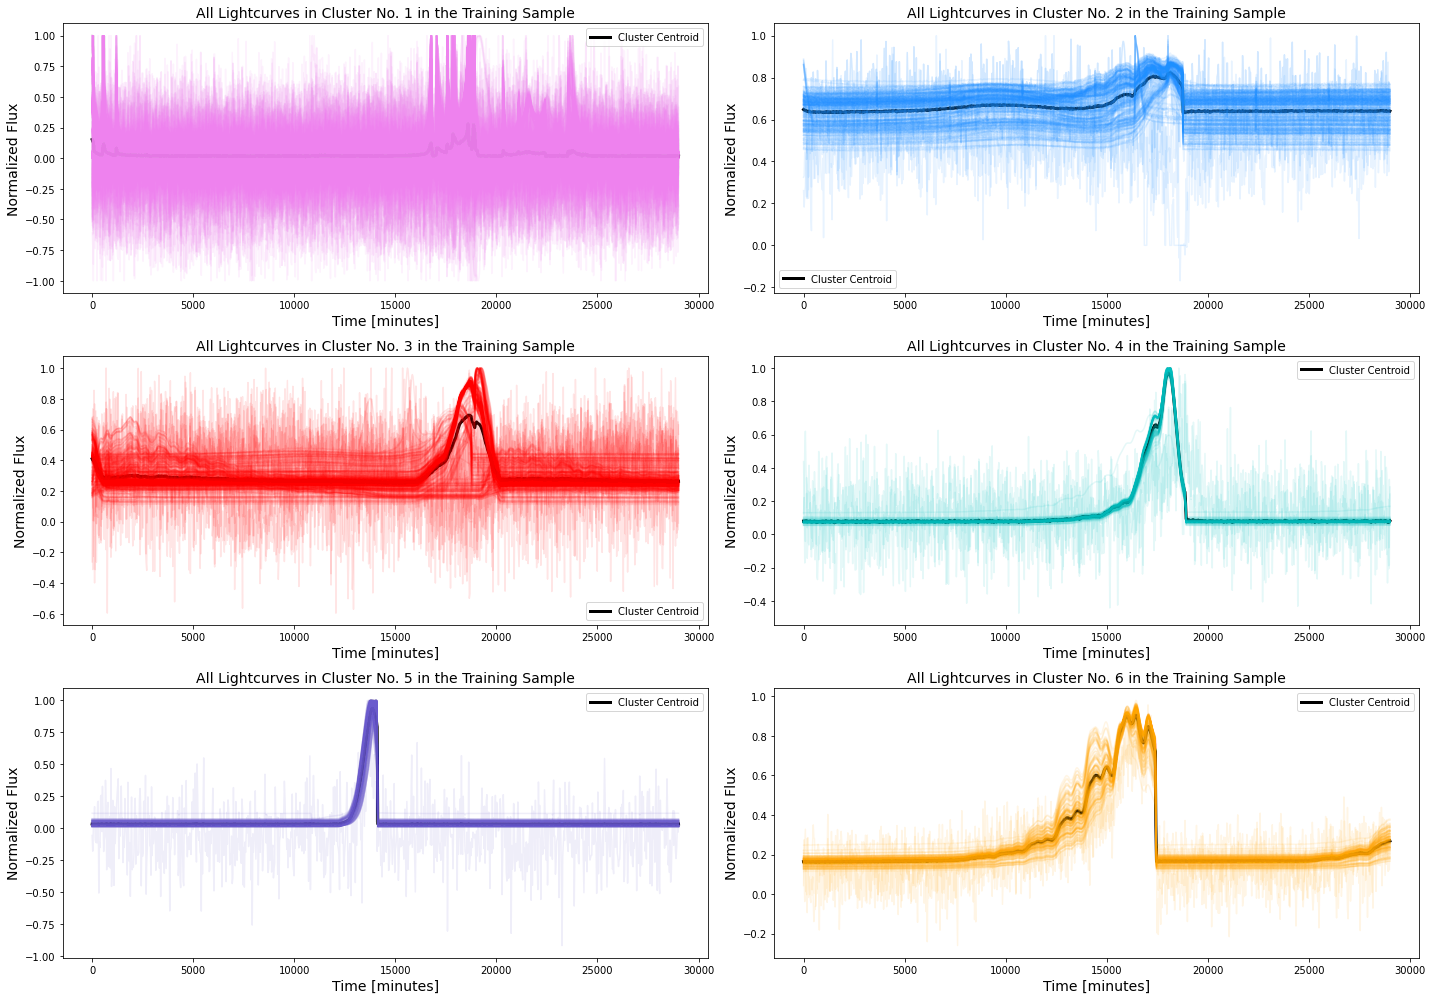

In [62]:
plot_clusters(6)

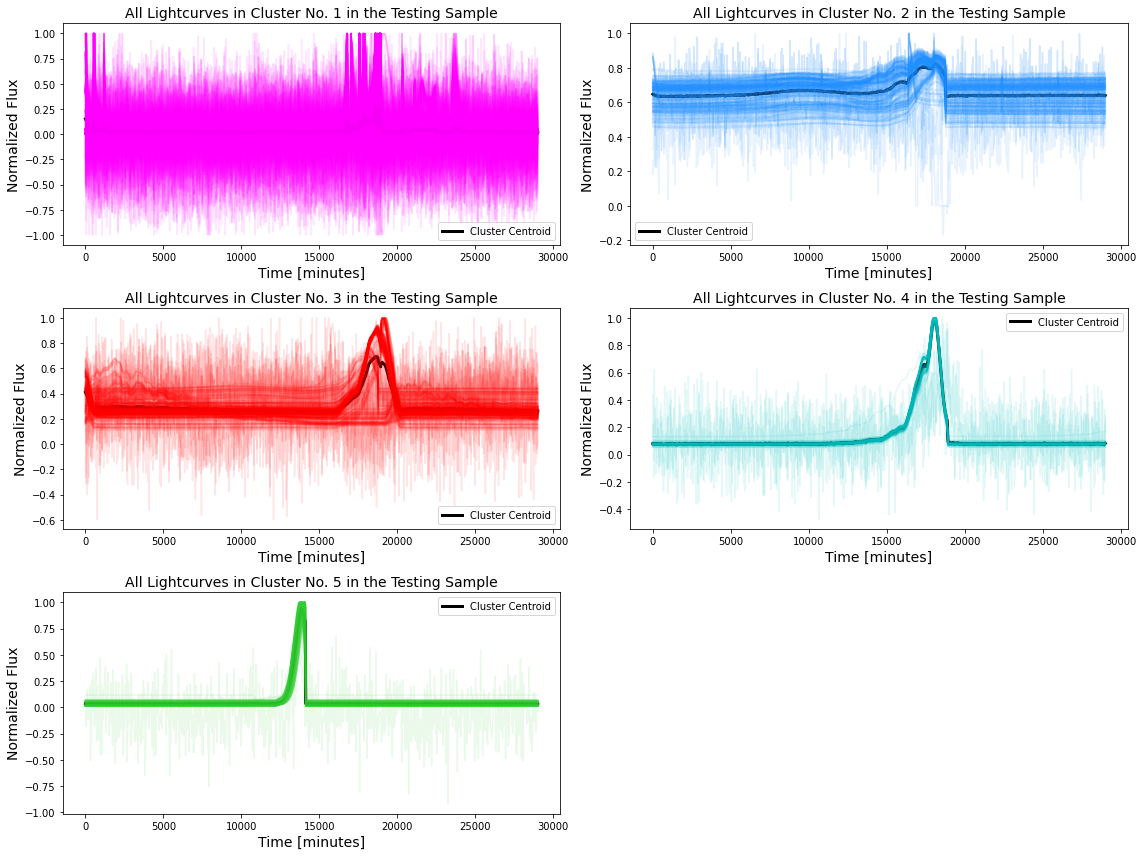

In [53]:
plot_clusters(6, testing = True)

In [11]:
# It's working!
# TODO: figure out why we have negative values

### Use an elbow plot to optimize the number of clusters to use

### Plot the optimal K-means configuration